In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

In [2]:
batch_size = 512

x2_dist = dist.Normal(loc = 0, scale = 4)
x2_samples = x2_dist.sample_n(batch_size)

x1_dist = dist.Normal(loc=0.25 * torch.square(x2_samples), scale = torch.ones(batch_size, dtype=torch.float32))
x1_samples = x1_dist.sample()
x_samples = torch.stack([x1_samples, x2_samples], axis = 1)

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


(-10.0, 10.0)

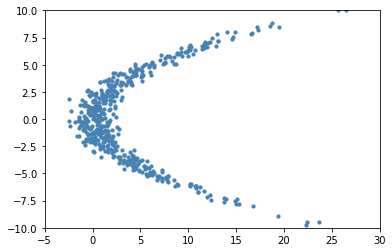

In [4]:
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=10, color='steelblue')
plt.xlim([-5, 30])
plt.ylim([-10, 10])

In [5]:
base_dist = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [6]:
base_x = base_dist.sample_n(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


(-10.0, 10.0)

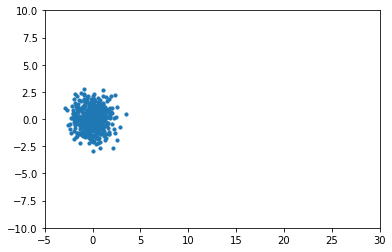

In [7]:
plt.scatter(base_x[:,0], base_x[:,1], s=10)
plt.xlim([-5, 30])
plt.ylim([-10, 10])

In [ ]:
class LeakyReLU():
  def __init__(self, alpha=0.5, validate_args = False, name="leaky_relu"):
    super(LeakyReLU, self).__init__(event_ndims=1, validate_args=validate_args, name=name)
    self.alpha = alpha

  def _forward(self, x):
    return torch.where(torch.greater_equal(x, 0), x, self.alpha * x)

  def _inverse(self, y):
    return torch.where(torch.greater_equal(y, 0), y, 1. / self.alpha * y)
  
  def _inverse_log_det_jacobians(self, y):
    event_dims = self.event_dims_tensor(y)
    I = torch.ones_like(y)
    J_inv = torch.where(torch.greater_equal(y, 0), I, 1.0 / self.alpha * I)
    log_abs_det_J_inv = torch.log(torch.abs(J_inv))
    return torch.sum(log_abs_det_J_inv, axis = event_dims)

In [ ]:
!pip install flowtorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 456 kB/s 


In [ ]:
import flowtorch.bijectors as bij
import flowtorch.distributions as distrib

In [ ]:
bijectors = bij.AffineAutoregressive()

In [ ]:
flow = distrib.Flow(base_dist, bijectors)

epoch 0 loss 38.75492858886719
epoch 500 loss 6.320026397705078
epoch 1000 loss 5.041219234466553
epoch 1500 loss 4.535808563232422
epoch 2000 loss 4.310124397277832
epoch 2500 loss 4.204442024230957
epoch 3000 loss 4.151463031768799
epoch 3500 loss 4.127219200134277
epoch 4000 loss 4.113890647888184
epoch 4500 loss 4.106302738189697
epoch 5000 loss 4.102781295776367
epoch 10000 loss 4.063714027404785


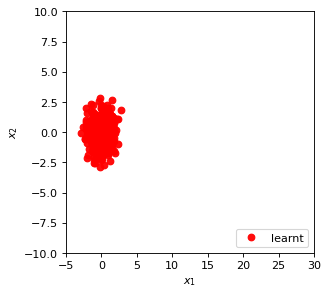

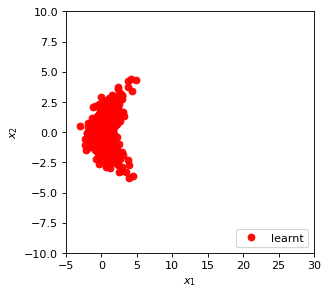

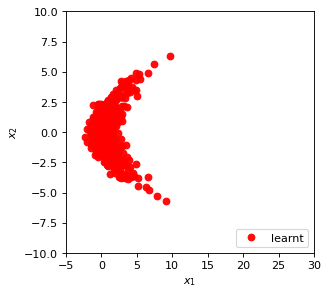

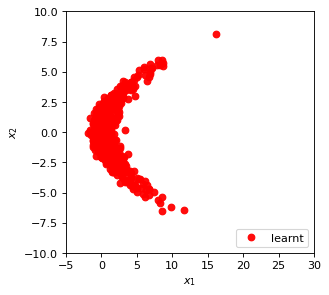

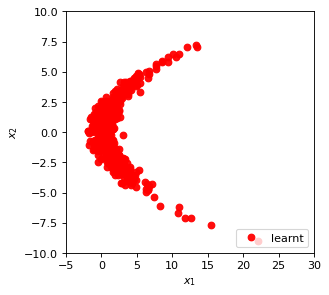

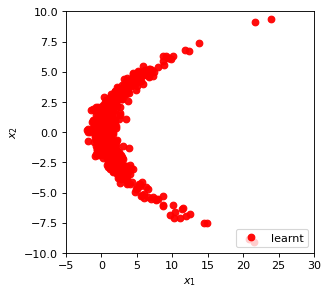

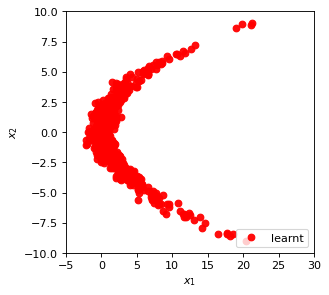

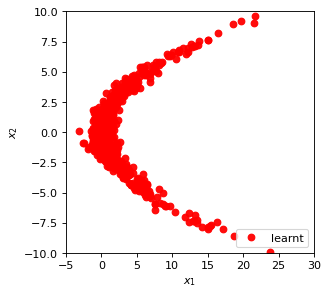

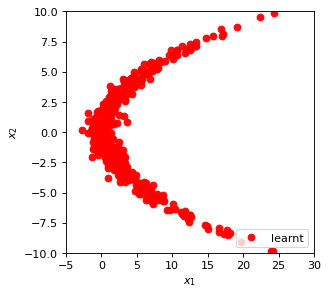

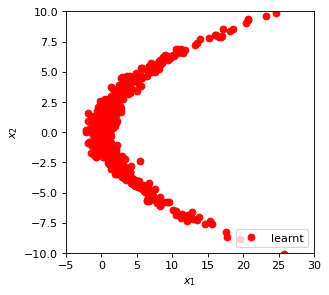

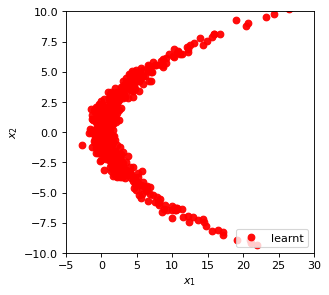

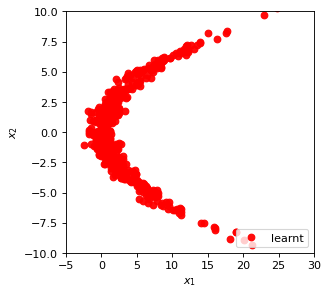

In [ ]:
# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=1e-3)
for idx in range(10001):
    opt.zero_grad()

    # Minimize KL(p || q)
    y = x_samples
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0 and idx < 5001 or idx == 10000:
        print('epoch', idx, 'loss', loss.item())

    # Save SVG
        y_learnt = (
            flow.sample(
                torch.Size(
                    [
                        batch_size,
                    ]
                )
            )
            .detach()
            .numpy()
        )

        plt.figure(figsize=(4, 4), dpi=80)
        plt.plot(
            y_learnt[:, 0],
            y_learnt[:, 1],
            "o",
            color="red",
            alpha=0.95,
            label="learnt",
        )
        plt.xlim([-5, 30])
        plt.ylim([-10, 10])
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
        plt.legend(loc="lower right", facecolor=(1, 1, 1, 1.0))

     

    loss.backward()
    opt.step()